In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [52]:
# IMPORT: Tableau Superstore dataset

df = pd.read_csv("../data/superstore_sample.csv")

In [53]:
# CHANGE: to non-numeric types

# Type Change: 2 columns -> str
df['Customer ID'] = df['Customer ID'].astype("string")
df['Product ID'] = df['Product ID'].astype("string")

# Type Change: 5 columns -> category 
df['Ship Mode'] = df['Ship Mode'].astype("category")
df['Segment'] = df['Segment'].astype("category")
df['Region'] = df['Region'].astype("category")
df['Category'] = df['Category'].astype("category")
df['Sub-Category'] = df['Sub-Category'].astype("category")

# Type Change: 2 columns -> datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [54]:
# CHANGE: datetime to int

df['Order Date'] = df['Order Date'].astype(int) / 10**14
df['Ship Date'] = df['Ship Date'].astype(int) / 10**14

In [55]:
# ASSIGN: ids to string id columns

id_columns = [
    "Customer ID",
    "Product ID",
]
for i in id_columns:
    df[i+'_id'] = df.groupby(i).ngroup()

In [56]:
# DROP: 10 Columns

# id: "Customer ID", "Product ID"
# no value: "Row ID", "Order ID", "Country"
# redundancy: "Customer Name", "Product Name", "City", "State", "Postal Code"

noval_columns = [
   "Row ID", "Order ID", "Country"
]
redundant_columns = [
    "Customer Name", "Product Name", 
    "City", "State", "Postal Code"
]
dropping_columns = id_columns + noval_columns + redundant_columns

df_f = df.drop(columns=dropping_columns)

In [57]:
# PROFILE: exploratory analysis

import ydata_profiling as yp

report_super_f = df_f.profile_report()
report_super_f.to_file(output_file="0409_super_f_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
# ENCODE: 5 categories' datatype

category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    "Sub-Category" #17
]

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    df_f = df_f.join(ohe_df)

In [59]:
# DROP & NORMALIZE

scaler = StandardScaler()
scaled_df_f = scaler.fit_transform(
    df_f.drop(category_columns, axis=1))

# Testing For Methods ->>>>>

In [60]:
# perform PCA
pca = PCA(n_components=4)
pca_df = pca.fit_transform(scaled_df_f)

# print the results
print(("Explained Variance: %s") % (pca.explained_variance_ratio_))

Explained Variance: [0.08286326 0.07538842 0.05179821 0.04563117]


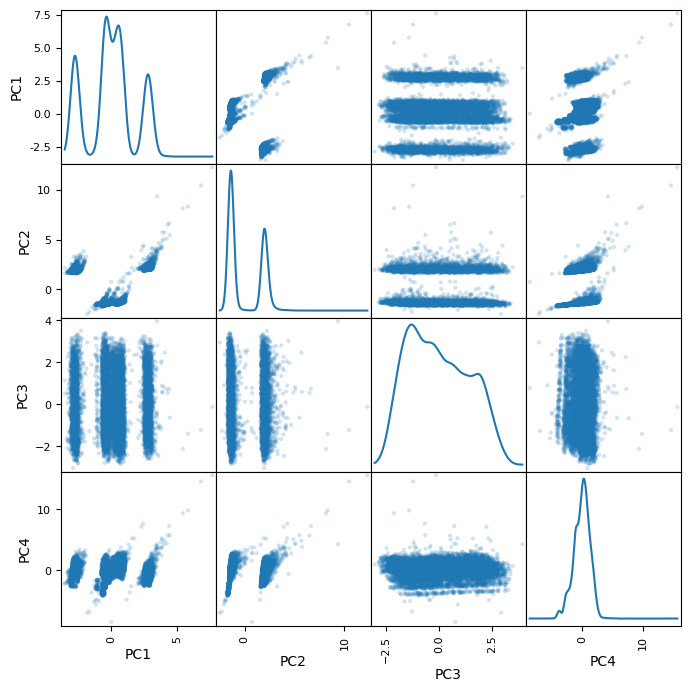

In [61]:
from pandas.plotting import scatter_matrix

pca_df_pd = pd.DataFrame(pca_df, columns=['PC1', 'PC2', 'PC3', 'PC4'])
scatter_matrix(pca_df_pd, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

## From PCA, dataset is unlikely to encompass a linear structure -->>>>

In [62]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(scaled_df_f, test_size=0.33)

from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
scaled_df_f, _ = load_digits(return_X_y = True)
kpca = KernelPCA(n_components=None, kernel='sigmoid', fit_inverse_transform=True, alpha=0.1)
# df_transformed = kpca.fit_transform(scaled_df_f)

test_pca = pca.fit(train).transform(test)
test_kpca = kpca.fit(train).transform(test)
# print(df_transformed.shape)

ValueError: There are significant negative eigenvalues (0.0817083 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

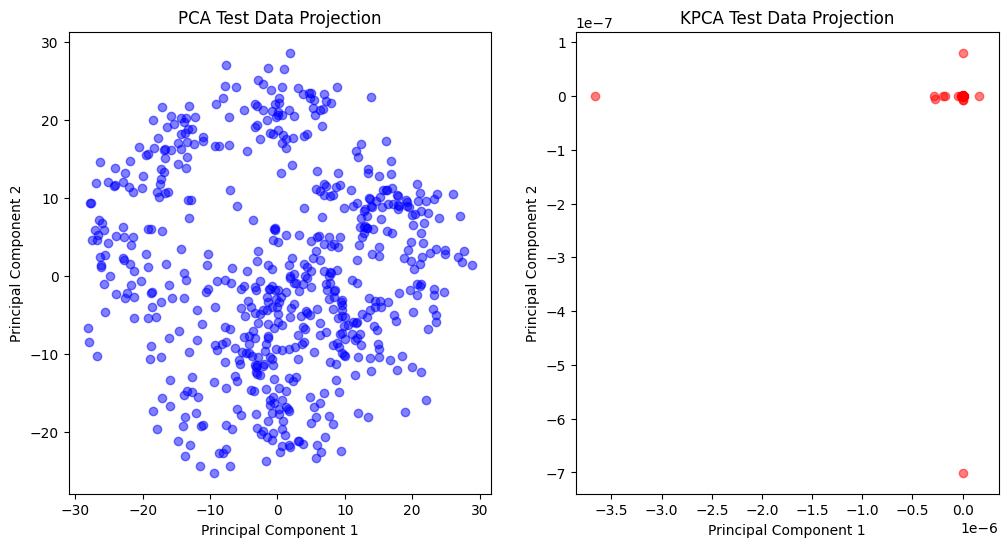

In [ ]:
# Plot the transformed test data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Test Data Projection')

plt.subplot(1, 2, 2)
plt.scatter(test_kpca[:, 0], test_kpca[:, 1], c='red', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KPCA Test Data Projection')

plt.show()

## kernel PCA is not working as well ->>>>>

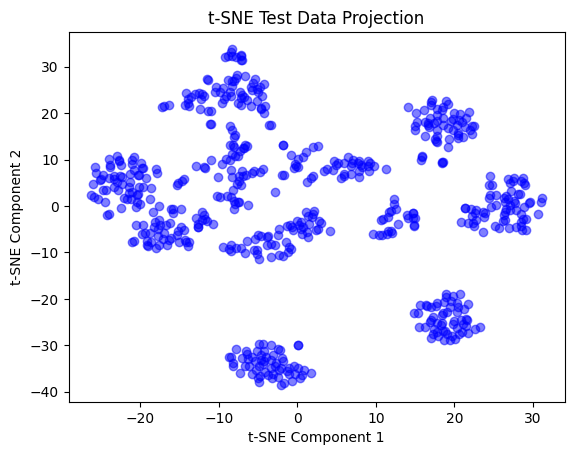

In [ ]:
# t-Distributed Stochastic Neighbor Embedding

from sklearn.manifold import TSNE
train, test = train_test_split(scaled_df_f, test_size=0.33)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train)
test_tsne = tsne.fit_transform(test)

# Plot the transformed test data
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Test Data Projection')
plt.show()

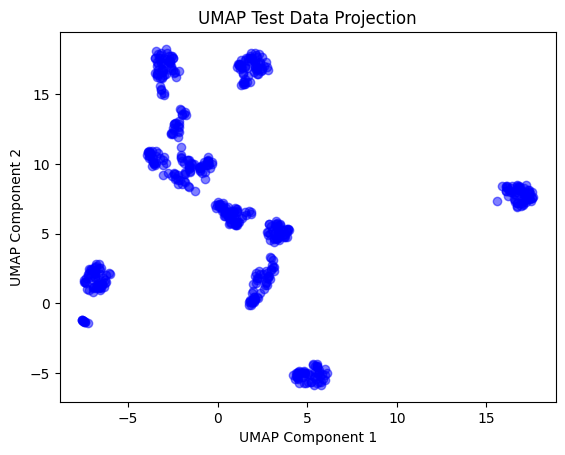

In [ ]:
# Uniform Manifold Approximation and Projection

from umap import UMAP
train, test = train_test_split(scaled_df_f, test_size=0.33)

# Apply UMAP
umap = UMAP(n_components=2, random_state=42)
train_umap = umap.fit_transform(train)
test_umap = umap.transform(test)

# Plot the transformed test data
plt.scatter(test_umap[:, 0], test_umap[:, 1], c='blue', marker='o', alpha=0.5)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Test Data Projection')
plt.show()

## t-sne, umap both could be pluasible to use in dimensionality reduction -->>>>